In [1]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 55.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102753 sha256=535924470ae45f99b4d08aa382d141fb65ce091d8a191564ea91fca333b844ff
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [3]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from eofs.xarray import Eof


def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """
    n_eofs=5
    min_co2 = 0.
    max_co2 = 9500
    def normalize_co2(data):
       return data / max_co2

    def un_normalize_co2(data):
        return data * max_co2

    min_ch4 = 0.
    max_ch4 = 0.8
    def normalize_ch4(data):
       return data / max_ch4

    def un_normalize_ch4(data):
        return data * max_ch4
    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    # Compute EOFs for BC
    bc_solver = Eof(X['BC'])
    bc_eofs = bc_solver.eofsAsCorrelation(neofs=n_eofs)
    bc_pcs = bc_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Compute EOFs for SO2
    so2_solver = Eof(X['SO2'])
    so2_eofs = so2_solver.eofsAsCorrelation(neofs=n_eofs)
    so2_pcs = so2_solver.pcs(npcs=n_eofs, pcscaling=1)

    # Convert to pandas
    bc_df = bc_pcs.to_dataframe().unstack('mode')
    bc_df.columns = [f"BC_{i}" for i in range(n_eofs)]

    so2_df = so2_pcs.to_dataframe().unstack('mode')
    so2_df.columns = [f"SO2_{i}" for i in range(n_eofs)]

    # Bring the emissions data back together again and normalise
    inputs = pd.DataFrame({
        "CO2": normalize_co2(X["CO2"].data),
        "CH4": normalize_ch4(X["CH4"].data)
    }, index=X["CO2"].coords['time'].data)

    # Combine with aerosol EOFs
    inputs = pd.concat([inputs, bc_df, so2_df], axis=1)

    return X, length_all,(so2_solver, bc_solver),inputs


def prepare_predictand(data_sets,data_path,time_reindex=True):

    if isinstance(data_sets, str):
        data_sets = [data_sets]
    Y_all = []
    length_all = []

    for file in data_sets:

        data = xr.open_dataset(data_path + f"/outputs_{file}.nc")
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    if isinstance(data_sets, str):
        data_sets = [data_sets]
    inp = xr.concat([xr.open_dataset(data_path + f"/outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    # Convert the precip values to mm/day
    inp["pr"] *= 86400
    inp["pr90"] *= 86400


    return Y, length_all,inp


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [5]:
cwd = os.getcwd()


train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [6]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr,X_length,solver,X_inputs = prepare_predictor(train_files,train_path)
y_train_xr,y_train_length,y_train_inputs  = prepare_predictand(train_files,train_path)

#Testing set
X_test_xr, _ , solver, X_test_inputs = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ , y_test_inputs = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [88]:
X_train_xr

<xarray.Dataset>
Dimensions:    (time: 753, longitude: 144, latitude: 96)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 ... 745 746 747 748 749 750 751 752
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    CO2        (time) float64 0.1883 0.3772 0.5738 0.7788 ... 0.0 0.0 0.0 0.0
    SO2        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 2.124e-14
    CH4        (time) float64 0.03131 0.03174 0.03218 0.03261 ... 0.0 0.0 0.0
    BC         (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 3.793e-16

In [13]:
X_train_df = X_inputs
X_test_df = X_test_inputs
# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 12) (86, 12)


In [ ]:
#y_train_df

In [14]:
#var  = 'pr'
y_train = y_train_xr['diurnal_temperature_range'].data
y_test  = y_test_xr['diurnal_temperature_range'].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)

(753, 96, 144, 1) (86, 96, 144, 1)


In [104]:
X_test_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
2015,0.161692,0.467171,-1.848120,-2.997157,-1.370376,0.819766,4.357775,-1.810749,-3.237989,-2.440683,1.265845,4.054046
2016,0.165480,0.467151,-1.770935,-2.737577,-1.240559,0.522505,3.037672,-1.691530,-2.936678,-1.919931,0.909636,2.709123
2017,0.169305,0.467130,-1.693749,-2.477998,-1.110743,0.225244,1.717568,-1.572311,-2.635367,-1.399180,0.553427,1.364200
2018,0.173166,0.467110,-1.616564,-2.218418,-0.980926,-0.072018,0.397465,-1.453091,-2.334057,-0.878428,0.197218,0.019278
2019,0.177064,0.467090,-1.539379,-1.958839,-0.851110,-0.369279,-0.922639,-1.333872,-2.032746,-0.357676,-0.158991,-1.325645
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,0.469755,0.352172,1.435515,-0.896998,0.488574,-1.507813,-0.363902,1.296894,-0.984599,0.962083,-1.545024,0.549357
2097,0.471474,0.351729,1.454090,-0.900787,0.404335,-1.639047,-0.594456,1.311303,-1.044758,0.990998,-1.733059,0.606642
2098,0.473128,0.351287,1.472666,-0.904576,0.320097,-1.770280,-0.825010,1.325713,-1.104916,1.019913,-1.921094,0.663928
2099,0.474718,0.350845,1.491241,-0.908365,0.235858,-1.901514,-1.055564,1.340122,-1.165075,1.048827,-2.109129,0.721214


In [110]:
X_test_inputs['time'] = range(2015,2101)

In [111]:
X_test_inputs

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,time
2015,0.161692,0.467171,-1.848120,-2.997157,-1.370376,0.819766,4.357775,-1.810749,-3.237989,-2.440683,1.265845,4.054046,2015
2016,0.165480,0.467151,-1.770935,-2.737577,-1.240559,0.522505,3.037672,-1.691530,-2.936678,-1.919931,0.909636,2.709123,2016
2017,0.169305,0.467130,-1.693749,-2.477998,-1.110743,0.225244,1.717568,-1.572311,-2.635367,-1.399180,0.553427,1.364200,2017
2018,0.173166,0.467110,-1.616564,-2.218418,-0.980926,-0.072018,0.397465,-1.453091,-2.334057,-0.878428,0.197218,0.019278,2018
2019,0.177064,0.467090,-1.539379,-1.958839,-0.851110,-0.369279,-0.922639,-1.333872,-2.032746,-0.357676,-0.158991,-1.325645,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,0.469755,0.352172,1.435515,-0.896998,0.488574,-1.507813,-0.363902,1.296894,-0.984599,0.962083,-1.545024,0.549357,2096
2097,0.471474,0.351729,1.454090,-0.900787,0.404335,-1.639047,-0.594456,1.311303,-1.044758,0.990998,-1.733059,0.606642,2097
2098,0.473128,0.351287,1.472666,-0.904576,0.320097,-1.770280,-0.825010,1.325713,-1.104916,1.019913,-1.921094,0.663928,2098
2099,0.474718,0.350845,1.491241,-0.908365,0.235858,-1.901514,-1.055564,1.340122,-1.165075,1.048827,-2.109129,0.721214,2099


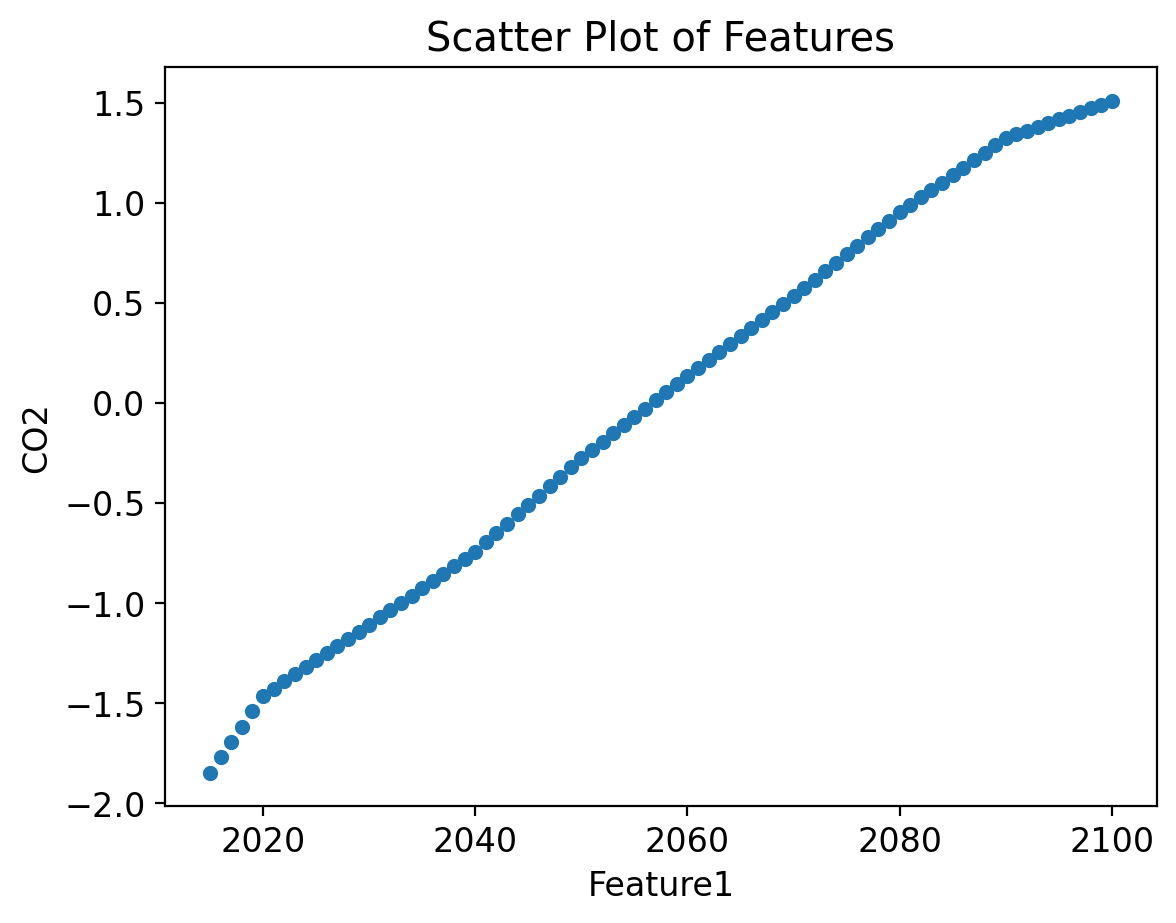

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
x = range(2014,2100)
# Assuming X_train is your DataFrame containing the features
# Create a scatter plot of the features
X_test_inputs.plot.scatter(x=['time'], y= ['BC_0'])

# Set labels and title
plt.xlabel('Feature1')
plt.ylabel('CO2')
plt.title('Scatter Plot of Features')

# Display the plot
plt.show()


In [90]:
#X_inputs['time'] = range(1850, 2100)

In [71]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 32  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernal_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 400

In [72]:
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96,144,1)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48,72,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (12,18,32)
x = Flatten()(x) # shape: (6912,1)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,1)


z_mean    = Dense(latent_dim, name="z_mean")(x) # shape: (2,1)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,1)


def sample_latent_features(distribution):
    """
    This function takes previously calculated mean & variance,
    and returns back a latent encoding vector.
    """

    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random


z         = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 32)   544         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 32)   16416       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 32)   16416       ['conv2d_1[0][0]']         

In [73]:
decoder_input = Input(shape=(latent_dim,)) # shape: (2,1)
cond_input    = Input(shape=(X_train.shape[1],)) # shape: (2,1)
x = keras.layers.Concatenate(axis=1)([decoder_input]) # shape: (4,1)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,1)
x = Reshape((12, 18, n_filters))(x) # shape: (12,18,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (48,72,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (96,144,32)
decoder_output = Conv2DTranspose(1, kernal_size, activation="linear", padding="same")(x) # shape: (96,144,1)
decoder_model = Model([decoder_input,cond_input], decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 6912)         20736       ['concatenate[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 12, 18, 32)   0           ['dense_1[0][0]']                
                                                                                            

In [74]:
encoded = encoder_model(encoder_inputs)
decoded = decoder_model([encoded,cond_input])
autoencoder = Model([encoder_inputs,cond_input], decoded)

In [75]:
def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*96*144

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss


In [76]:
autoencoder.compile(loss=get_loss(z_mean,z_log_var),
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder (Functional)           (None, 2)            254724      ['input_2[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 decoder (Functional)           (None, 96, 144, 1)   70497       ['encoder[0][0]',            

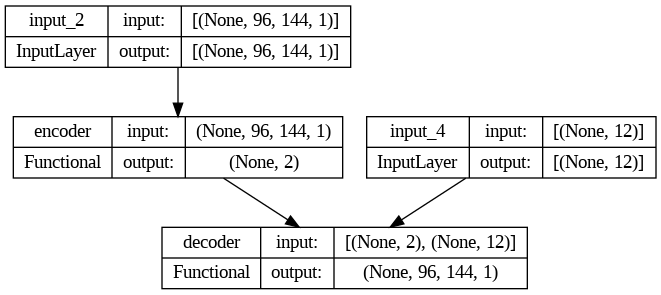

In [77]:
tf.keras.utils.plot_model(autoencoder, to_file='model_summary.png', show_shapes=True)

In [78]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = autoencoder.fit([y_train,X_train], y_train,
                          epochs=num_epochs,
                          batch_size=minibatch_size,
                          validation_split=0.2)

Train on 602 samples, validate on 151 samples
Epoch 1/400
602/602 [==============================] - ETA: 0s - loss: 16075.2997

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


602/602 [==============================] - 29s 49ms/sample - loss: 16075.2997 - val_loss: 6205.6333
Epoch 2/400
602/602 [==============================] - 28s 46ms/sample - loss: 15722.6664 - val_loss: 6219.0417
Epoch 3/400
602/602 [==============================] - 28s 47ms/sample - loss: 15717.0991 - val_loss: 6262.2671
Epoch 4/400
602/602 [==============================] - 25s 42ms/sample - loss: 15701.0386 - val_loss: 6317.5736
Epoch 5/400
602/602 [==============================] - 27s 46ms/sample - loss: 15658.9031 - val_loss: 6378.1619
Epoch 6/400
602/602 [==============================] - 28s 46ms/sample - loss: 15510.2230 - val_loss: 6535.7623
Epoch 7/400
602/602 [==============================] - 32s 53ms/sample - loss: 14881.0218 - val_loss: 7744.9954
Epoch 8/400
602/602 [==============================] - 29s 48ms/sample - loss: 13360.9943 - val_loss: 10675.7606
Epoch 9/400
512/602 [========================>.....] - ETA: 3s - loss: 11492.6799

KeyboardInterrupt: ignored

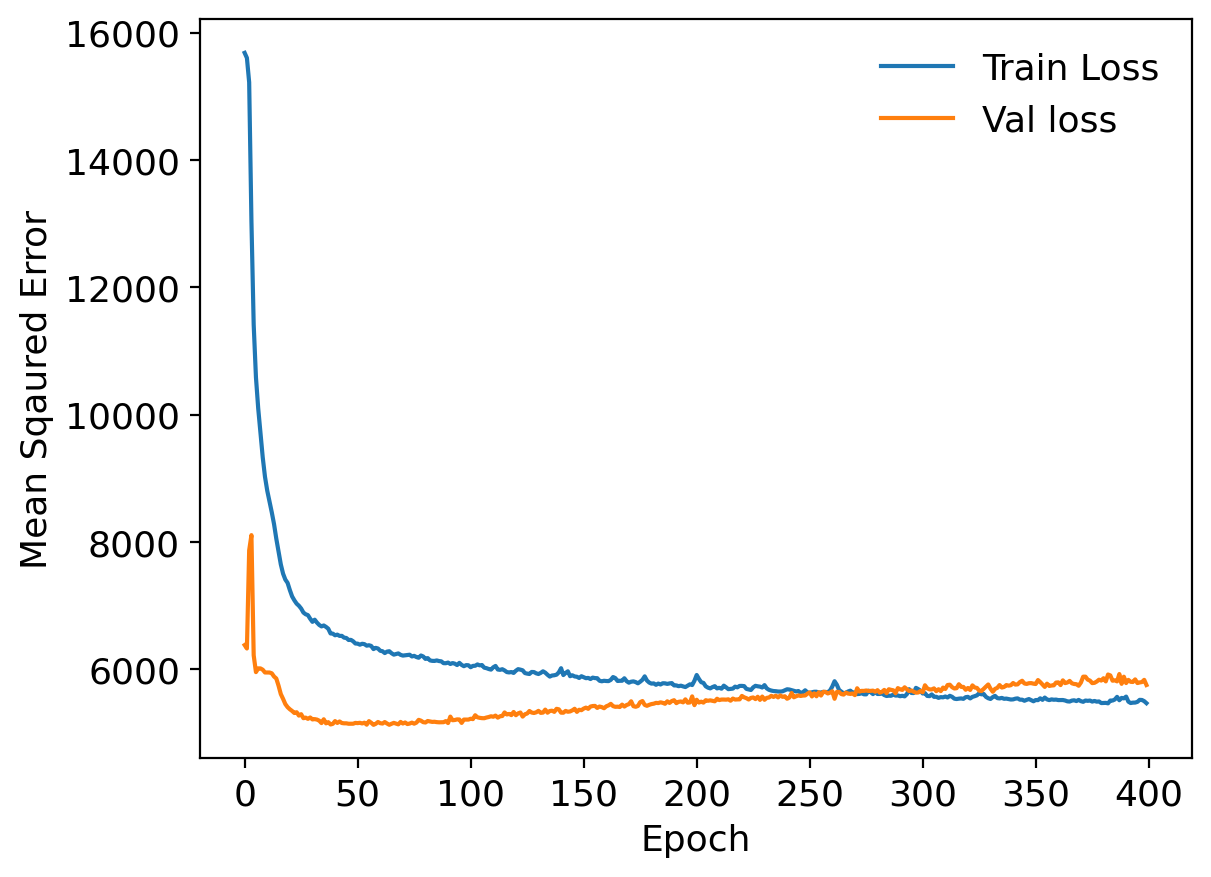

In [ ]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqaured Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()


plot_history(history)

In [ ]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])
#print(y_test_pre)
y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values,
                               'latitude': y_test_xr.latitude.values,
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(diurnal_temperature_range=(['time', 'latitude', 'longitude'], y_test_pre)))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_test_pre

<xarray.Dataset>
Dimensions:    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    pr         (time, latitude, longitude) float32 -0.02955 -0.0329 ... -0.6275

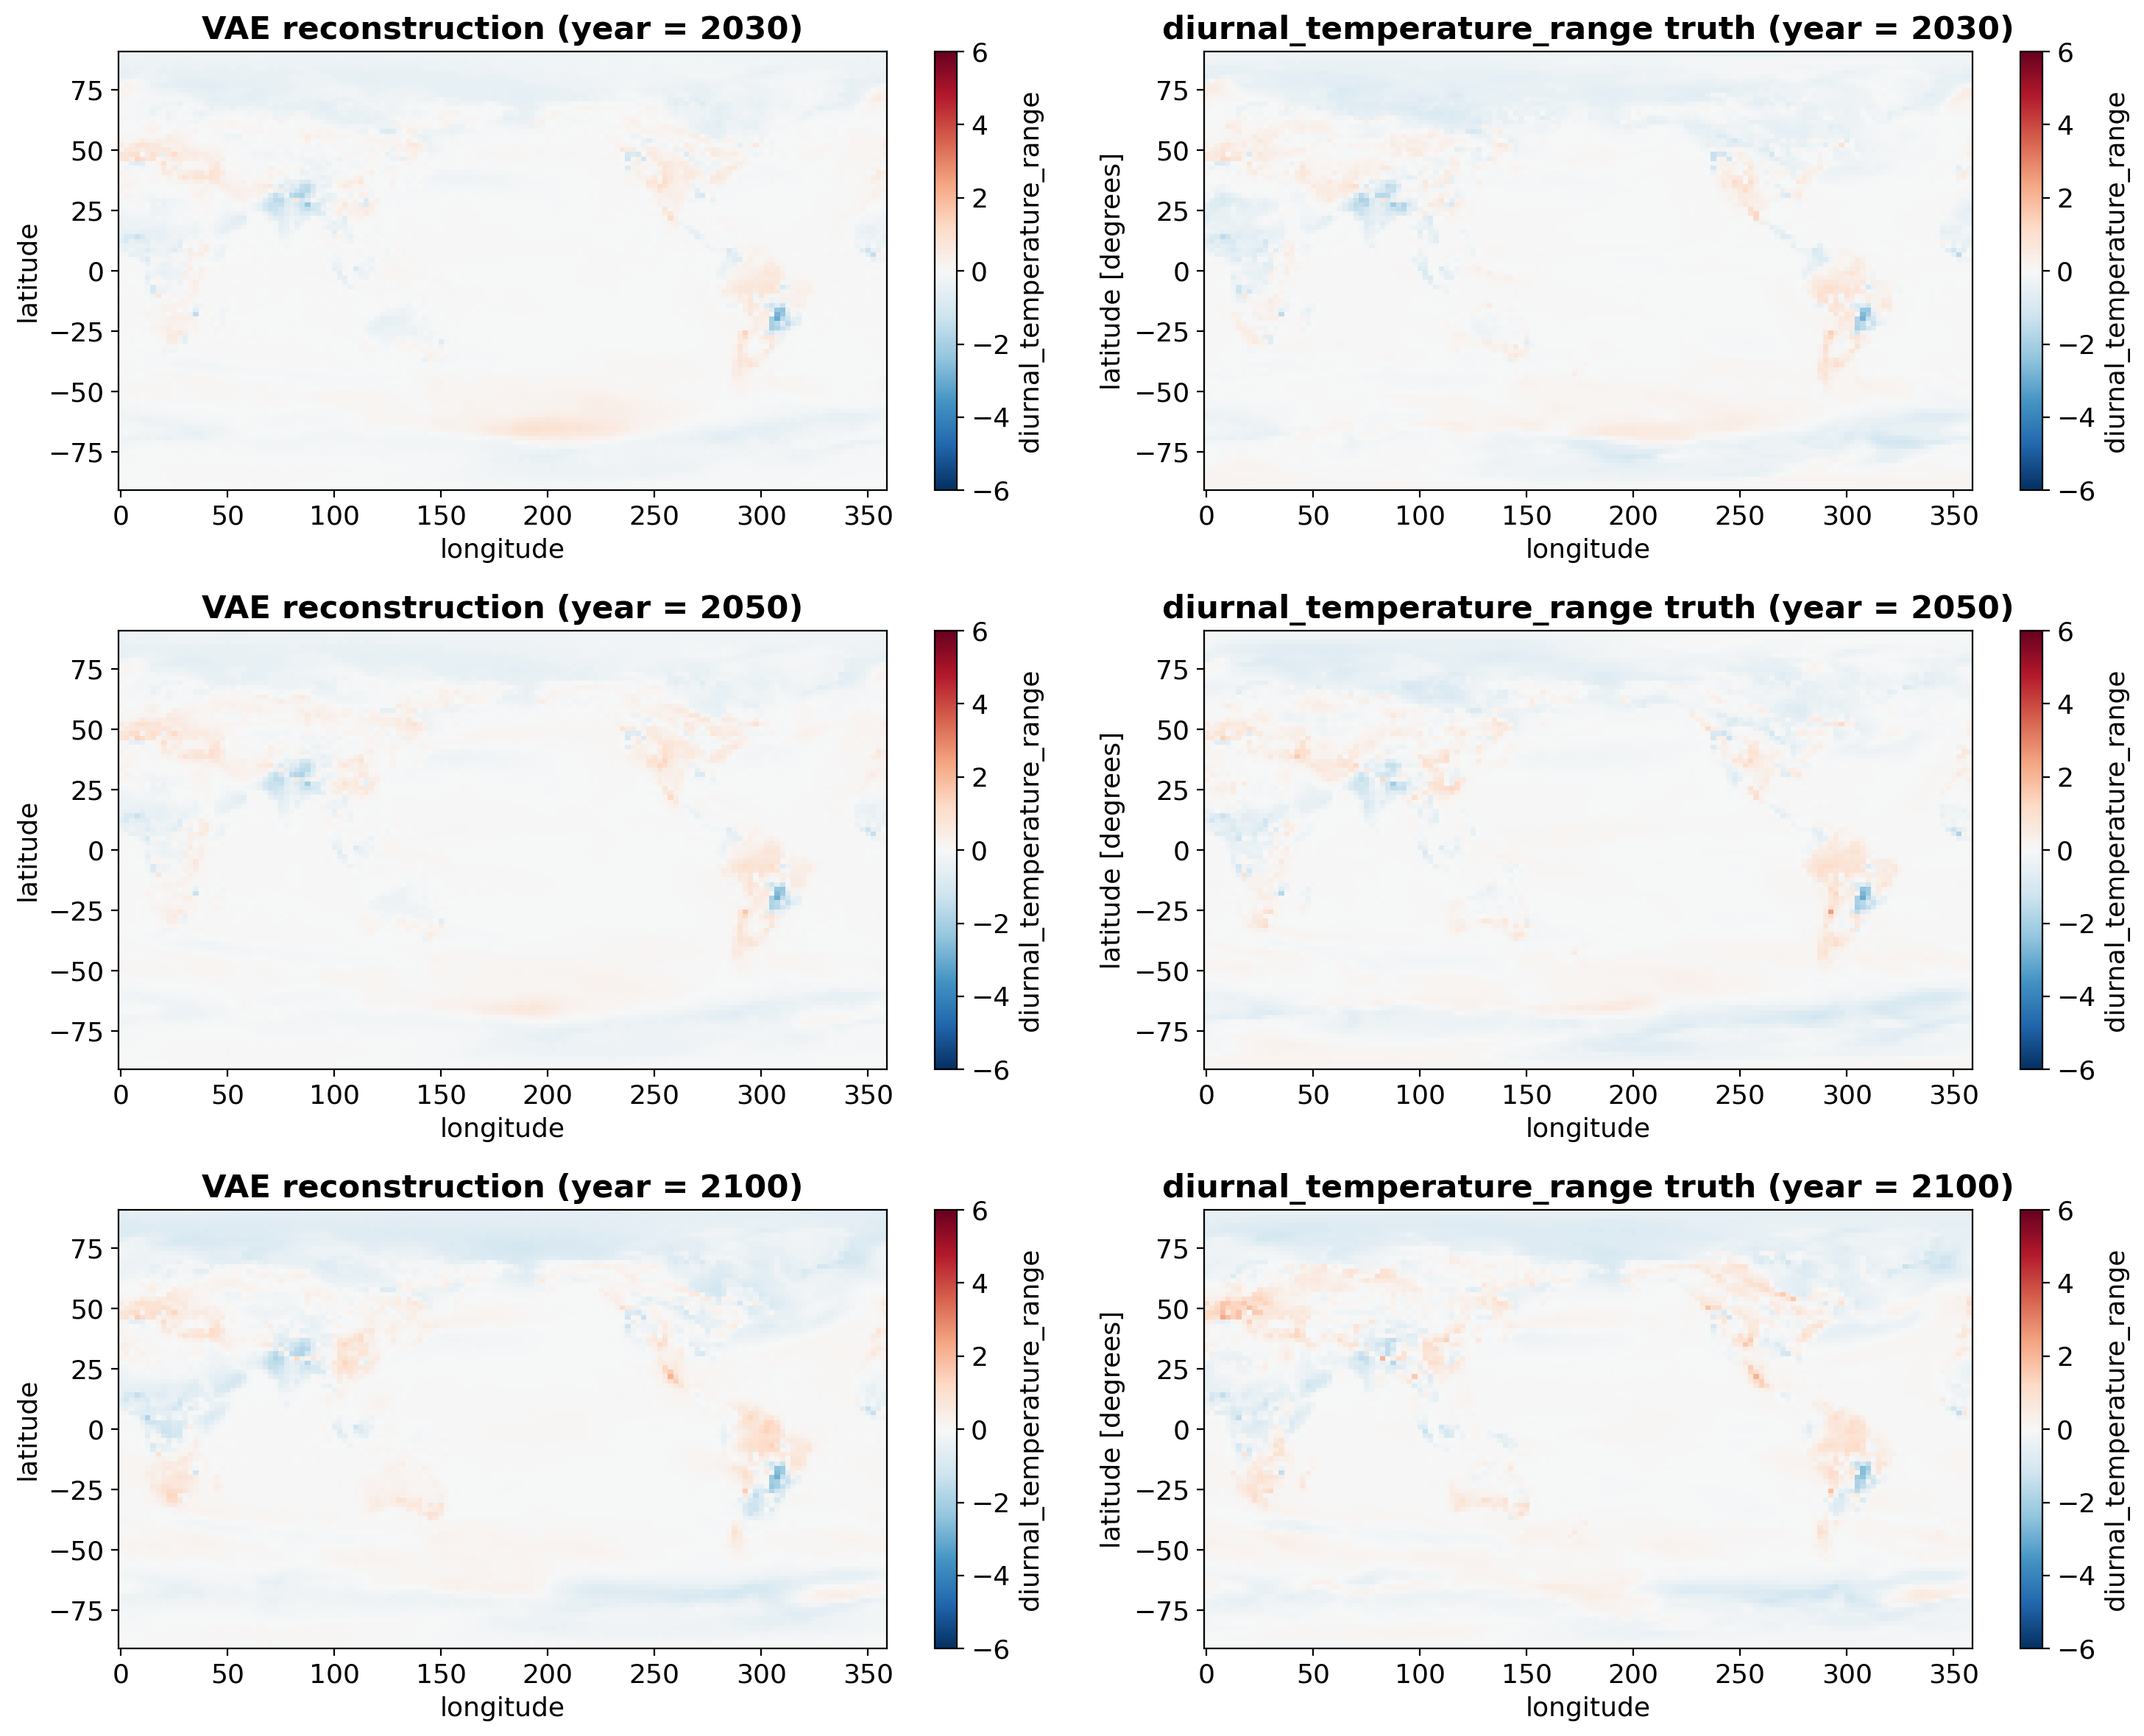

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.diurnal_temperature_range.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.diurnal_temperature_range.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.diurnal_temperature_range.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.diurnal_temperature_range.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.diurnal_temperature_range.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.diurnal_temperature_range.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth pr from ssp245 simulations
    else:
        ax.set_title(f'diurnal_temperature_range truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

In [ ]:
y_test_xr

<xarray.Dataset>
Dimensions:                    (latitude: 96, longitude: 144, time: 86)
Coordinates:
  * latitude                   (latitude) float64 -90.0 -88.11 ... 88.11 90.0
  * longitude                  (longitude) float64 0.0 2.5 5.0 ... 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 0.09798 .....
    tas                        (time, latitude, longitude) float32 1.475 ... ...
    pr                         (time, latitude, longitude) float32 3.614e-07 ...
    pr90                       (time, latitude, longitude) float64 8.739e-07 ...

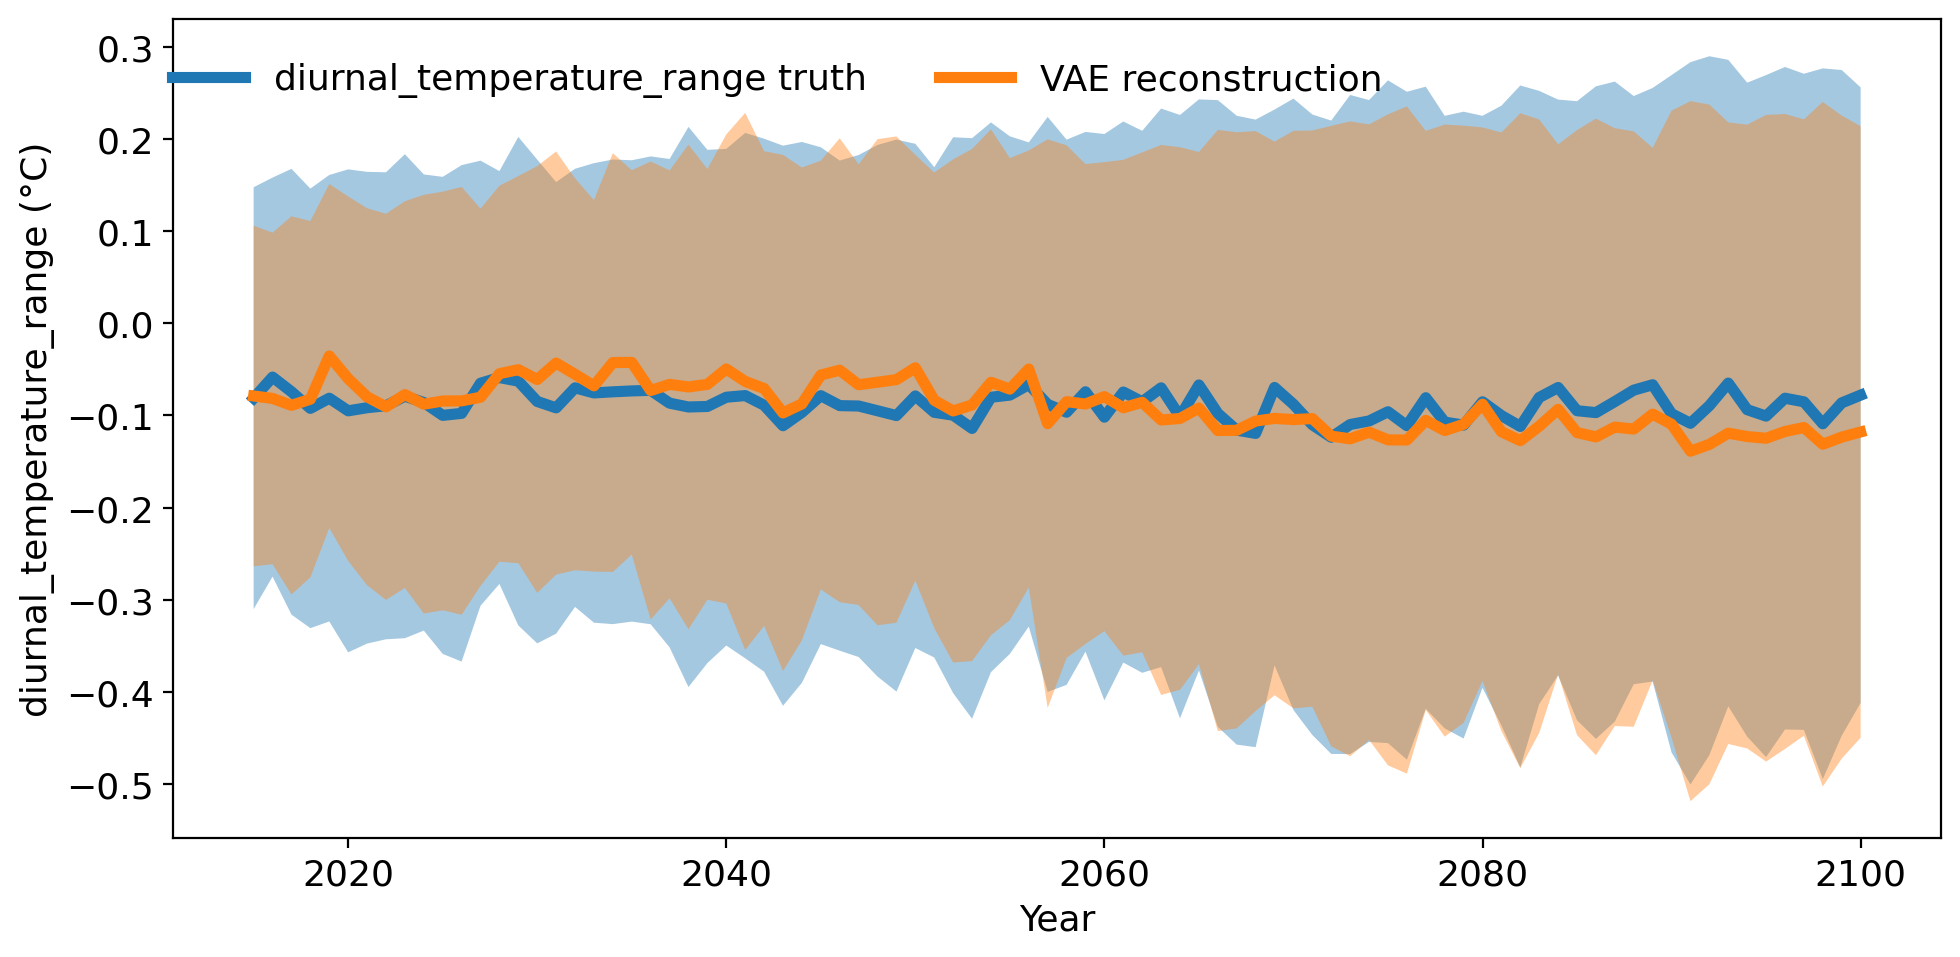

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

yr,mean_truth = mean_std_plot(y_test_xr['diurnal_temperature_range'],color='tab:blue',label='diurnal_temperature_range truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['diurnal_temperature_range'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('diurnal_temperature_range (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

In [ ]:
y_test_pre


<xarray.Dataset>
Dimensions:                    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
  * latitude                   (latitude) float64 -90.0 -88.11 ... 88.11 90.0
  * longitude                  (longitude) float64 0.0 2.5 5.0 ... 355.0 357.5
Data variables:
    diurnal_temperature_range  (time, latitude, longitude) float32 -0.02333 ....

[Text(0.5, 1.0, 'Difference')]

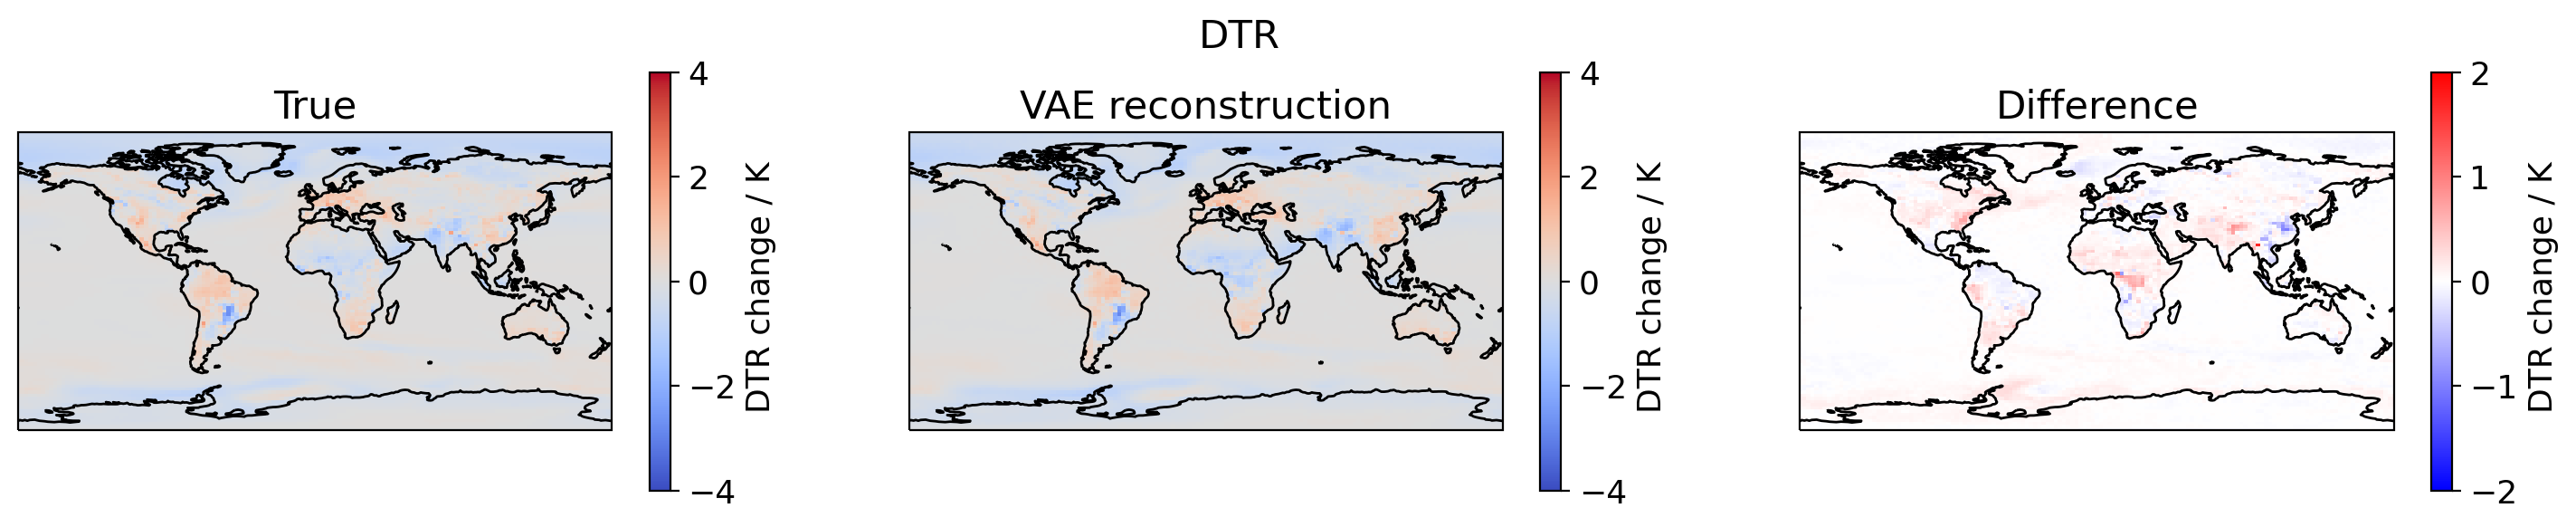

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## DTR
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('DTR')

# Test
plt.subplot(131, projection=proj)
y_test_xr.diurnal_temperature_range.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
y_test_pre.diurnal_temperature_range.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-4,
                              cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='VAE reconstruction')

# Difference
difference = y_test_xr.diurnal_temperature_range - y_test_pre.diurnal_temperature_range
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"DTR change / K "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')